# Pectoral Muscle Removal from Mammograms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab

### Ensuring same orientation of all images
In order for the algorithm to generalize over all mammograms, we first right-orient all images. To detect left-oriented breast images, we simply compare the number of nonzero pixels on both half of the images.

This is quite a rudimentary way to detect orientation, and works because the the background pixels are completely black and thus gives us an idea of the location of breast on either half of the image

In [2]:
from glob import glob
image_list = glob("/mnt/f/EMBED_1080_ROI_JPG/EMBED_1080_ROI_JPG/images/*/*/*/*/*.jpg")
print(len(image_list))

4770


In [10]:
import pandas as pd
get_orig_path = lambda x: x.replace("/mnt/NAS2/mammo/anon_dicom", '/mnt/f/EMBED_1080_ROI_JPG/EMBED_1080_ROI_JPG/images').replace('.dcm', '_resized.jpg')
df = pd.read_csv("data/tables/EMBED_OpenData_metadata_reduced.csv")
df = df[df['FinalImageType'] == '2D']
screen_idx = df['StudyDescription'].apply(lambda x: x.lower().find('screen') > 0)
df = df[screen_idx]
df['new_path'] = df['anon_dicom_path'].apply(get_orig_path)
path_to_description = dict(zip(df['new_path'], df['SeriesDescription']))

/tmp/ipykernel_2277288/3618476544.py:3: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/tables/EMBED_OpenData_metadata_reduced.csv")


In [12]:
mlo_images = [path for path in image_list if 'MLO' in path_to_description.get(path, '')]
print(len(mlo_images))

2157


### Image pre-processing

We first remove the text in the image by computing the area of each separate contour in the binarized image. We then use OTSU mask to cut the unnecessary background region and then rotate the image to the right orientation

In [13]:
from PIL import Image
import cv2

def otsu_mask(img):
    median = np.median(img)
    _, thresh = cv2.threshold(img, median, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def otsu_cut(x):
    if isinstance(x, Image.Image):
        x = np.array(x)
    if x.max() <= 1:
        x = (x * 255).astype(np.uint8) # Convert to 8-bit if not already
    mask = otsu_mask(x)
    # Convert to NumPy array if not already

    # Check if the matrix is empty or has no '1's
    if mask.size == 0 or not np.any(mask):
        return Image.fromarray(x)

    # Find the rows and columns where '1' appears
    rows = np.any(mask == 255, axis=1)
    cols = np.any(mask == 255, axis=0)

    # Find the indices of the rows and columns
    min_row, max_row = np.where(rows)[0][[0, -1]]
    min_col, max_col = np.where(cols)[0][[0, -1]]

    # Crop and return the submatrix
    x = x[min_row:max_row+1, min_col:max_col+1]
    img = Image.fromarray(x)
    return img

In [14]:
from skimage import io
from skimage import color
import cv2

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image



In [15]:
def remove_text_label(image):
    # Convert the image to a NumPy array if it's a PIL image
    if isinstance(image, Image.Image):
        image = np.array(image)
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8) # Convert to 8-bit if not already

    # Binarize the image using a naive non-zero thresholding
    binary_image = (image > 0).astype(np.uint8) * 255
    
    # Apply Gaussian blur to the binarized image
    blurred_image = cv2.GaussianBlur(binary_image, (5, 5), 0)
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(blurred_image, connectivity=8)
    
    # Create an output image to store the result
    output_image = image.copy()
    
    # Remove small connected components
    for i in range(1, num_labels):  # Start from 1 to skip the background
        area = stats[i, cv2.CC_STAT_AREA]
        if area < 1e4:  # Threshold for small areas, adjust as needed
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            output_image[y:y+h, x:x+w] = 0  # Set the region to black
    
    return Image.fromarray(output_image)


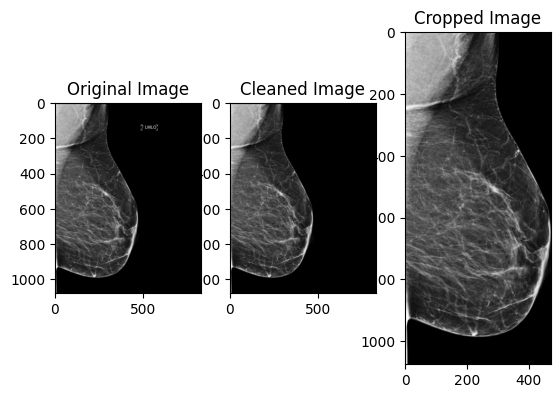

In [95]:
img = read_image(image_list[0])
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
cleaned_img = remove_text_label(img)
plt.subplot(1, 3, 2)
plt.imshow(cleaned_img, cmap='gray')
plt.title('Cleaned Image')
img = otsu_cut(cleaned_img)
plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Cropped Image')
plt.show()

### Enhance image contrast

Newer Mammography usually has better resolution and clearer than the old ones. We use histogram equalization to enhance the image contrast and highlight the pectoral region

In [96]:
def enhance_contrast(image):
    # Convert the image to a NumPy array if it's a PIL image
    if isinstance(image, Image.Image):
        image = np.array(image)
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8) # Convert to 8-bit if not already

    # Apply histogram equalization
    enhanced_image = cv2.equalizeHist(image)
    
    return Image.fromarray(enhanced_image)

### Applying canny edge detection

In [97]:
from skimage.feature import canny
from skimage.filters import sobel

def mask_bottom_fn(image):
    # mask out the bottom 10% of the image
    mask = np.ones(image.shape)
    mask[int(image.shape[0]*0.9):, :] = 0
    masked_image = image * mask
    return masked_image

def mask_right_fn(image):
    # mask out the right 40% of the image
    mask = np.ones(image.shape)
    mask[:, int(image.shape[1]*0.6):] = 0
    masked_image = image * mask
    return masked_image

def apply_canny(image, mask_bottom=True, mask_right=False):
    if mask_bottom:
        image = mask_bottom_fn(image)
    if mask_right:
        image = mask_right_fn(image)
    canny_img = canny(image, 6)
    return sobel(canny_img)

In [100]:
def gaussian_blur(image):
    # Convert the image to a NumPy array if it's a PIL image
    if isinstance(image, Image.Image):
        image = np.array(image)
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8) # Convert to 8-bit if not already

    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (5, 5,), 10)
    
    return Image.fromarray(blurred_image)

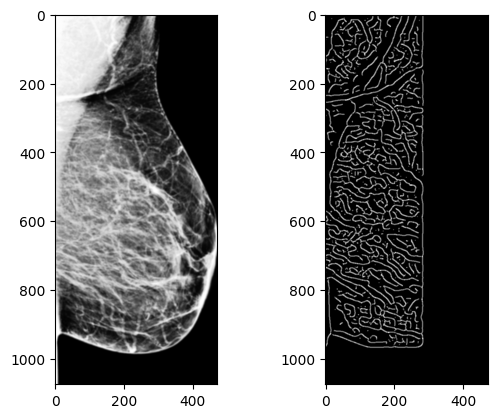

In [101]:
img = enhance_contrast(img)
img = gaussian_blur(img)
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
canny_img = apply_canny(np.array(img), mask_bottom=True, mask_right=True)
plt.subplot(1, 2, 2)
plt.imshow(canny_img, cmap='gray')
plt.show()

### Applying Hough transform
Once we have obtained the edges using the Canny Edge Detector, we can apply Hough transform and make a list of output lines.

Each line is represented by an object with the following attributes
 - `dist`: perpendicular distance of the line from origin
 - `angle`: angle (in degrees) made by the perpendicular from the positive x-axis. This perpendicular is dropped on the line from the origin
 - `point1`, `point2`: two points on the line
 
Note: The x-axis and y-axis are oriented as shown in the image ouputs below.

In [36]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img, verbose=False):
    h, theta, d = hough_line(canny_img)
    lines = list()
    if verbose:
        print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        if verbose:
            print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        angle = max(angle, 1e-3)
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

### Shortlisting lines
We need to shortlist possible candidates for pectoral segmentation. A simple criteria for shortlisting can be simply checking whether the `angle` and `dist` values of each line lies inside a particular interval.

The intervals are `MIN_ANGLE <= angle <= MAX_ANGLE` and `MIN_DIST <= dist <= MAX_DIST`.

These 4 parameters can be easily learned given a bigger dataset of mammograms. However, for now these have been picked manually using judgement on the given 5 images, and seem to work well.

#### TODO: consider make the dist threshold to be adaptive wrt. to the image size

In [110]:
def shortlist_lines(lines, image_width=None, verbose=False):
    MIN_ANGLE = 5
    MAX_ANGLE = 60
    MIN_DIST  = 5
    MAX_DIST  = 300
    if image_width:
        W = image_width
        MIN_DIST = max(MIN_DIST, 0.01 * W)
        MAX_DIST = min(MAX_DIST, 0.65 * W)
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    shortlisted_lines.sort(key=lambda x: x['angle'])
    if verbose:
        print('\nShorlisted lines')
        for i in shortlisted_lines:
            print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
    return shortlisted_lines

### Removing pectoral region
If more than one line is shortlisted, we select the one which will cause the least loss of information (the safest approach).

For this, we sort these lines by their distance from origin `dist` and pick the nearest line. Then we simply set the value to zero of those pixels enclosed within a polygon formed by the picked line and the border of the image.

In [111]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

### Pick the correct line that segment the pectoral region

Consider the situation with more than one lines in the shortlist, we want the pick the line that keep as much breast region as possible while correctly separate the pectoral region.

we note that the pectoral region usually has a different contrast than the breast region (due to its tissue composition), so we compute the STD of the ROI for each line in the shortlist and pick the one with smallest STD, namely, most tissue in the region is identical.

In [112]:
def pick_line(image, shortlist_lines):
    if len(shortlist_lines) == 0:
        return [], 100
    best_line = None
    min_std = np.inf
    for line in shortlist_lines:
        rr, cc = remove_pectoral([line])
        rr = np.clip(rr, 0, image.shape[0]-1)
        cc = np.clip(cc, 0, image.shape[1]-1)
        segmented_roi = image[rr, cc]
        # ignore background regions
        segmented_roi = segmented_roi.flatten()[segmented_roi > 0]
        target_std = np.std(segmented_roi)
        if target_std < min_std:
            min_std = target_std
            best_line = line
    return [best_line], min_std

### Displaying final result
The result for all the five images is displayed below. We can easily compare the removed pectoral area with the original image.

#### TODO: rotate the image back to the correct orientation after all processing

In [113]:
import os
std_list = []
def display_image(filename, verbose=False, dest=None, show_img=True):
    image = read_image(filename)
    image = remove_text_label(image)
    image = otsu_cut(image)
    image = enhance_contrast(image)
    # rescale to 0-1
    image = np.array(image) / 255
    canny_image = apply_canny(image, mask_right=False)
    lines = get_hough_lines(canny_image, verbose)
    W = image.shape[1]
    shortlisted_lines = shortlist_lines(lines, image_width=W, verbose=verbose)
    shortlisted_lines, std = pick_line(image, shortlisted_lines)
    std_list.append(std)
    
    fig, axes = plt.subplots(1, 5, figsize=(12,8))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])
    for line in lines:
        axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[2].set_title('Shortlisted Lines')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
    
    if shortlisted_lines:
        first_line = shortlisted_lines[0]
        angle = first_line['angle']
        x1, y1 = first_line['point1']
        x2, y2 = first_line['point2']
        if x1 == 0:
            center = (x1, y1)
        elif x2 == 0:
            center = (x2, y2)
        elif y1 == 0:
            center = (x1, y1)
        elif y2 == 0:
            center = (x2, y2)
        else:
            center = (image.shape[1] // 2, image.shape[0] // 2)
        # double the image width to prevent cropping during rotation
        new_width = 2 * image.shape[1]
        # Expand the image with 0s according to the new width
        expanded_image = np.zeros((image.shape[0], new_width))
        expanded_image[:, :image.shape[1]] = image
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotate_image = cv2.warpAffine(expanded_image, M, (expanded_image.shape[1], expanded_image.shape[0]))
        rotate_image = otsu_cut(rotate_image)
        axes[3].set_title('Rotated Image')
        axes[3].imshow(rotate_image, cmap=pylab.cm.gray)
        axes[3].axis('on')
    
        rr, cc = remove_pectoral(shortlisted_lines)
        rr = np.clip(rr, 0, image.shape[0]-1)
        cc = np.clip(cc, 0, image.shape[1]-1)
        image[rr, cc] = 0
        axes[4].set_title('Pectoral muscle removed')
        axes[4].imshow(image, cmap=pylab.cm.gray)
        axes[4].axis('on') 
        if dest:
            filename = filename.split('/')[-1]
            dest = os.path.join(dest, filename)
            plt.savefig(dest, bbox_inches='tight')
    else:
        axes[3].axis('off')
        axes[4].axis('off')
        if dest:
            filename = filename.split('/')[-1]
            dest = os.path.join(dest, filename)
            plt.savefig(dest, bbox_inches='tight')
    if show_img:
        plt.show()
    plt.close()
    plt.cla()

100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


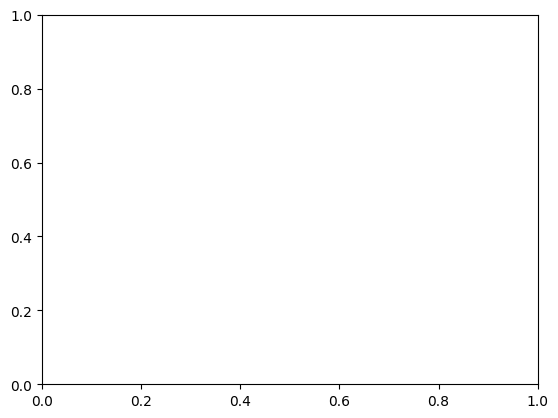

In [114]:
from tqdm import tqdm
for i in tqdm(range(0, 200)):
    display_image(mlo_images[i], verbose=False, dest='tmp/mask_bot_rel_dist', show_img=False)

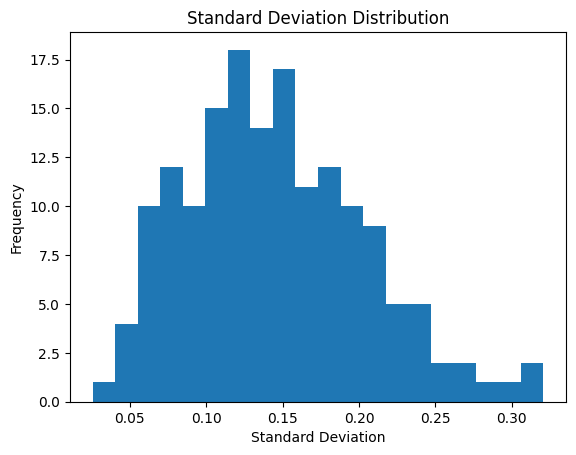

In [75]:
# plot std distribution in a histogram
std_list_arr = np.array(std_list)
plt.hist(std_list_arr[std_list_arr != 100], bins=20)
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.title('Standard Deviation Distribution')
plt.show()

True